In [249]:
import pydicom as dicom
import matplotlib.pyplot as plt
import pandas as pd
import glob
import numpy as np
import scipy.ndimage
from scipy.optimize import least_squares, minimize

# Reference Image
First, we load the reference image. It is a 3D pixel array (volume). We can visualize it to get an idea of which axis represents which plane.

In [4]:
ref_img_path = "./brain-data/icbm_avg_152_t1_tal_nlin_symmetric_VI.dcm"
ref_img = dicom.dcmread(ref_img_path)

print(ref_img.pixel_array.shape)

(193, 229, 193)


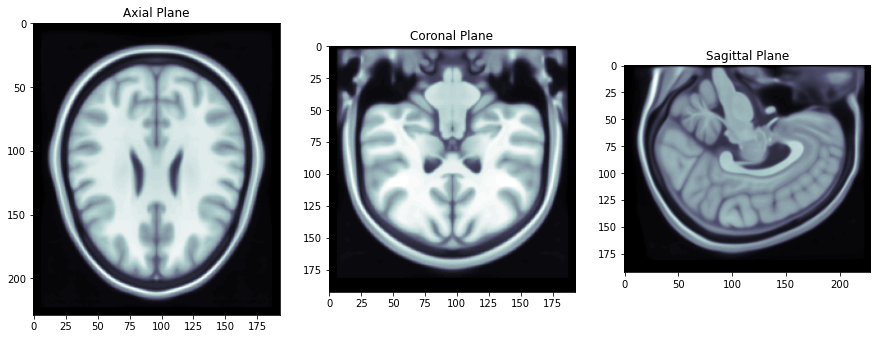

In [5]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(ref_img.pixel_array[100, :, :], cmap='bone')
plt.title("Axial Plane")

plt.subplot(1, 3, 2)
plt.imshow(ref_img.pixel_array[:,100, :], cmap='bone')
plt.title("Coronal Plane")

plt.subplot(1, 3, 3)
plt.imshow(ref_img.pixel_array[:, :, 100], cmap='bone')
plt.title("Sagittal Plane")

plt.show()

## Patient Volume (Input Volume)

In [7]:
patient_img_folder = "./brain-data/RM_Brain_3D-SPGR/*.dcm"
paths = glob.glob(patient_img_folder)
pixel_data = {}
for path in paths:
    dataset = dicom.dcmread(path)
    pixel_data[float(dataset.SliceLocation)] = dataset.pixel_array

In [8]:
def dicom2csv(extract = [],
              move_on = [(0x7FE0,0x0008), (0x7FE0,0x0009), (0x7FE0,0x0010)],
              folder_path = str(),
              csv_file_name = "metadata.csv",
              return_dataframe = False):
  
    '''
    Extract specific DICOM metadata from multiple DICOM files collected in a
    specified folder.
    ::Params
      - extract (list):
          The keywords of the DICOM attributes you want to extract.
      - move_on (list):
          The tags of the DICOM attributes you don't want to move on.
          By default,it contains a list of the tags of pixel data:
          [(0x7FE0,0x0008), (0x7FE0,0x0009), (0x7FE0,0x0010)]
          If you want to move on onto some attributes, it's recommended
          to append its unique tags in addition to pixel data tags.
      - folder_path (string):
          Path of the folder that contains the DICOM files.
      - csv_file_name (string):
          The name of the CSV file.
      - return_dataframe (bool):
          if True, returns a pandas dataframe of the extracted data for
          direct use.

    :: Returns
      - CSV file contains DICOM metadata specified the parameter extracted.
      - Pandas dataframe when return_dataframe is set to True.

    :: Example:
      dicom2csv(extract = ['StudyDate'],
                folder_path = 'content/dicomfolder',
                csv_file_name = "Study_Dates.csv",
                return_dataframe = True)
    '''
  
    # Initialize the meta dictionary that will have the specified attributes
    meta = {keyword:[] for keyword in extract}

    # List the files' names that we want to extract data from
    #dicom_files = glob.glob(folder_path+'/*.dcm')
    dicom_files = glob.glob(folder_path)

    # Iterate over each DICOM file in the folder and read it using dcmread()
    for file_path in dicom_files:
        # Read the DICOM file from the specified path
        dcm = dicom.dcmread(file_path)

        # Iterate over the DICOM attributes in the current DICOM file "dcm"
        for elem in dcm.iterall():
            # Ensure that the attribute is not a pixel data and it's one of the
            # required attributes
            if (elem.tag not in move_on) and (elem.keyword in extract):
                # Append the value of the current attribute
                meta[elem.keyword].append(elem.value)
            if (elem.tag not in move_on) and (elem.tag in extract):
                # Append the value of the current attribute
                meta[elem.keyword].append(elem.value)
            

    # Create a pandas dataframe for better use of the data
    df = pd.DataFrame(data=meta, columns = extract)

    # Create the CSV file with the specified name
    df.to_csv(csv_file_name, index=False)

    # Return the extracted dataframe for direct use
    if return_dataframe:
        return df

In [9]:
extract = ['SliceLocation', 'SliceThickness', 'SpacingBetweenSlices', 'ImagePositionPatient', 'InstanceNumber', 'PixelSpacing']
df = dicom2csv(extract = extract,
               move_on = [],
               folder_path = patient_img_folder,
               csv_file_name = 'data.csv', 
               return_dataframe = True)
df.head()

,SliceLocation,SliceThickness,SpacingBetweenSlices,ImagePositionPatient,InstanceNumber,PixelSpacing
0,90.059235,2.0,1.0,"[-130, -125.9024353, 90.0592346]",203,"[0.5078, 0.5078]"
1,90.059235,2.0,1.0,"[-130, -125.9024353, 90.0592346]",203,"[0.5078, 0.5078]"
2,-22.940765,2.0,1.0,"[-130, -125.9024353, -22.9407654]",90,"[0.5078, 0.5078]"
3,-22.940765,2.0,1.0,"[-130, -125.9024353, -22.9407654]",90,"[0.5078, 0.5078]"
4,-98.940765,2.0,1.0,"[-130, -125.9024353, -98.9407654]",14,"[0.5078, 0.5078]"


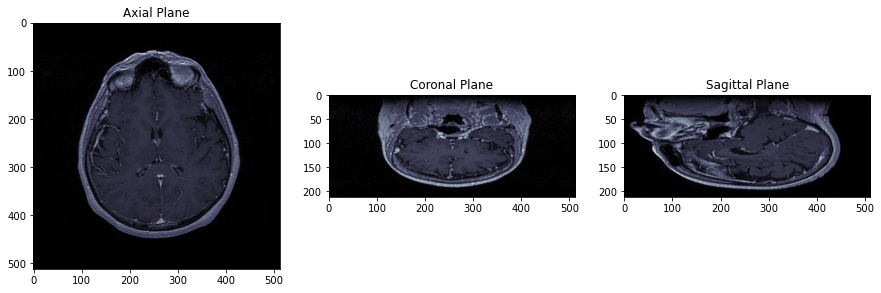

In [303]:
#(193, 229, 193)
sorted_pixel_data = {key:pixel_data[key] for key in sorted(pixel_data.keys())}
block_brain = np.array([i for i in sorted_pixel_data.values()])
block_brain.shape #(212, 512, 512)

plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(block_brain[110, :, :], cmap='bone', aspect = 1)
plt.title("Axial Plane")

plt.subplot(1, 3, 2)
plt.imshow(block_brain[:, 200, :], cmap='bone', aspect = 1)
plt.title("Coronal Plane")

plt.subplot(1, 3, 3)
plt.imshow(block_brain[:, :, 250], cmap='bone', aspect = 1)
plt.title("Sagittal Plane")

plt.show()

Some initial things I noticed from these visualizations are:
1. Dimensions are different. We have 3D blocks of (193, 229, 193) and (212, 512, 512).
2. There is a 180 degree rotation difference in the axial plane (image is upside down) which we should cater when coregistering the images
2. 

In [83]:
# Apply initial rotation transform on the images to align them and make coregistration simpler
# make voxels represents the same dimensions like Pedro mention
# make the pixel ranges similar
# Define metrics
# coregister

In [89]:
reference_array.shape, patient_array.shape

((193, 229, 193), (212, 512, 512))

## Initial Parameters 

1. The pixel spacing between the patient image and the reference image is different. Therefore, the patient image needs to be scaled  so that the 3D voxels represent the same dimensions.
2. We also need to do a 180 degree rotation 

In [17]:
def initial_rotation(img_dcm: np.ndarray, angle_in_degrees: float) -> np.ndarray:
    """ We are rotating on an axis parallel to the axial plane while passes through the centre of the body"""
    return scipy.ndimage.rotate(img_dcm, angle_in_degrees, axes=(1, 2), reshape=False)

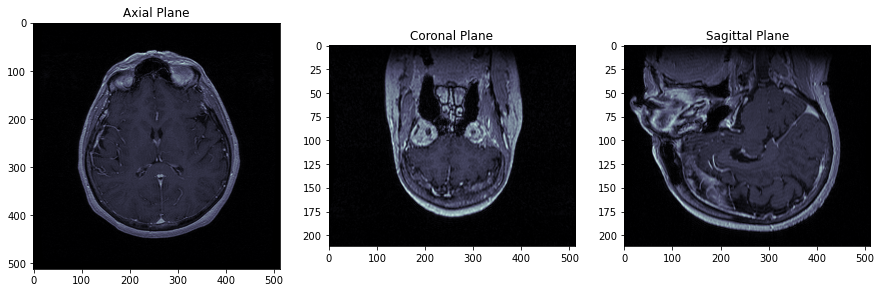

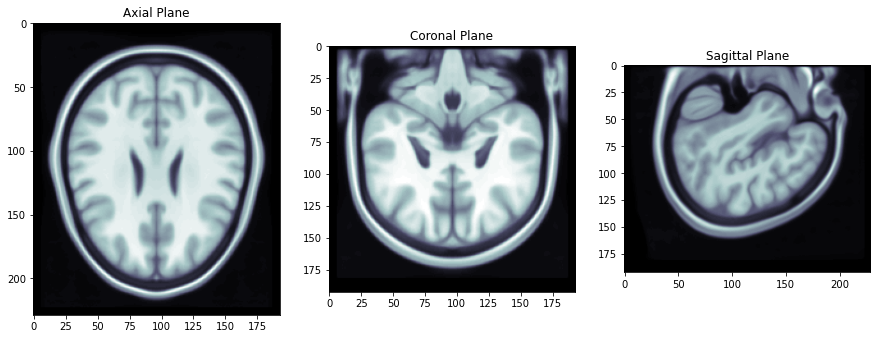

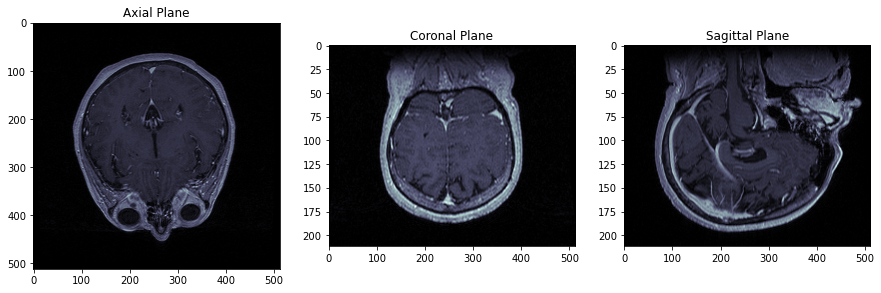

In [304]:
image_to_plot = block_brain

plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(image_to_plot[110, :, :], cmap='bone', aspect = 1)
plt.title("Axial Plane")

plt.subplot(1, 3, 2)
plt.imshow(image_to_plot[:, 150, :], cmap='bone', aspect = 1/0.507)
plt.title("Coronal Plane")

plt.subplot(1, 3, 3)
plt.imshow(image_to_plot[:, :, 250], cmap='bone', aspect = 1/0.507)
plt.title("Sagittal Plane")

plt.show()

image_to_plot = reference_array

plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(image_to_plot[100, :, :], cmap='bone', aspect = 1)
plt.title("Axial Plane")

plt.subplot(1, 3, 2)
plt.imshow(image_to_plot[:, 90, :], cmap='bone', aspect = 1)
plt.title("Coronal Plane")

plt.subplot(1, 3, 3)
plt.imshow(image_to_plot[:, :, 50], cmap='bone', aspect = 1)
plt.title("Sagittal Plane")

plt.show()

image_rotated = initial_rotation(block_brain, angle_in_degrees=180) 
image_to_plot = image_rotated

plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(image_to_plot[100, :, :], cmap='bone', aspect = 1)
plt.title("Axial Plane")

plt.subplot(1, 3, 2)
plt.imshow(image_to_plot[:, 150, :], cmap='bone', aspect = 1/0.507)
plt.title("Coronal Plane")

plt.subplot(1, 3, 3)
plt.imshow(image_to_plot[:, :, 250], cmap='bone', aspect = 1/0.507)
plt.title("Sagittal Plane")

plt.show()

In [19]:
# Pixel Spacing
patient_pixel_spacing = 0.507 #read from dicom header
scaling_factors = (1, 1/patient_pixel_spacing, 1/patient_pixel_spacing)
scaled_ref_image = scipy.ndimage.zoom(reference_array, scaling_factors, order=1) 

## Pad zeros

In [221]:
# pad zeros to the image to equalize the size

# Specify the desired new dimensions
pad_channels = (block_brain.shape[0] - scaled_ref_image.shape[0])
pad_height = (block_brain.shape[1] - scaled_ref_image.shape[1])
pad_width = (block_brain.shape[2] - scaled_ref_image.shape[2])

# Pad the array with zeros on the sides
padded_array = np.pad(scaled_ref_image, ((0, pad_channels), (0, pad_height), (0, pad_width)), mode='constant')

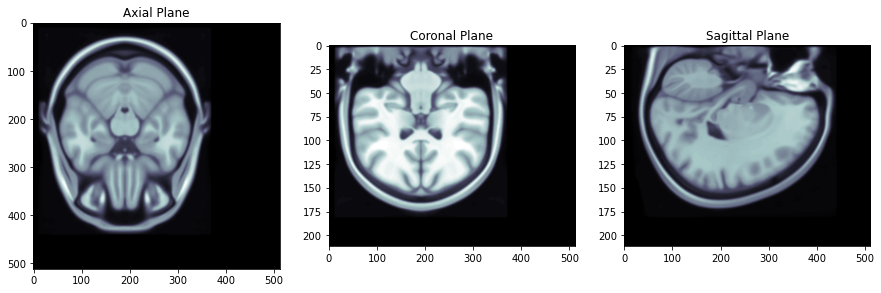

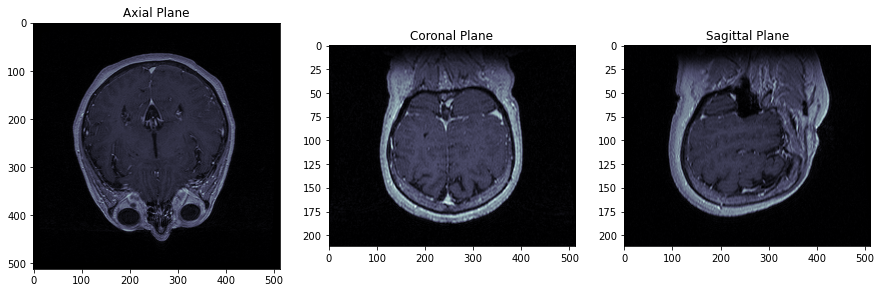

In [307]:
image_to_plot = padded_array

plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(image_to_plot[50, :, :], cmap='bone', aspect = 1)
plt.title("Axial Plane")

plt.subplot(1, 3, 2)
plt.imshow(image_to_plot[:, 200, :], cmap='bone', aspect = 1/0.507)
plt.title("Coronal Plane")

plt.subplot(1, 3, 3)
plt.imshow(image_to_plot[:, :, 150], cmap='bone', aspect = 1/0.507)
plt.title("Sagittal Plane")

plt.show()

image_to_plot = image_rotated

plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(image_to_plot[100, :, :], cmap='bone', aspect = 1)
plt.title("Axial Plane")

plt.subplot(1, 3, 2)
plt.imshow(image_to_plot[:, 150, :], cmap='bone', aspect = 1/0.507)
plt.title("Coronal Plane")

plt.subplot(1, 3, 3)
plt.imshow(image_to_plot[:, :, 150], cmap='bone', aspect = 1/0.507)
plt.title("Sagittal Plane")

plt.show()

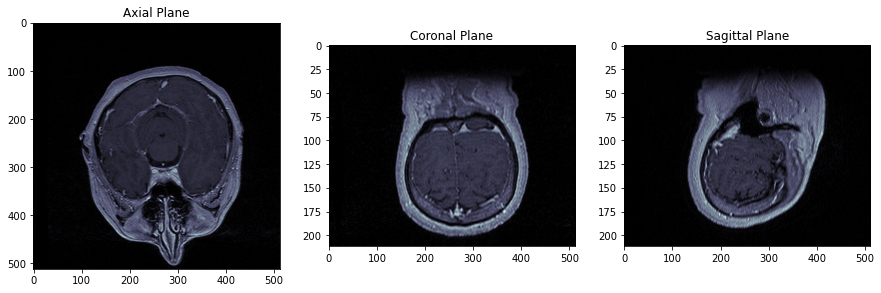

In [308]:
# Translation operation
translations = np.array([20, 20, 20])
translated_image = np.roll(image_rotated, translations.astype(int), axis=(0, 1, 2))

image_to_plot = translated_image

plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(image_to_plot[100, :, :], cmap='bone', aspect = 1)
plt.title("Axial Plane")

plt.subplot(1, 3, 2)
plt.imshow(image_to_plot[:, 150, :], cmap='bone', aspect = 1/0.507)
plt.title("Coronal Plane")

plt.subplot(1, 3, 3)
plt.imshow(image_to_plot[:, :, 150], cmap='bone', aspect = 1/0.507)
plt.title("Sagittal Plane")

plt.show()

In [252]:
def translate_img(image, translations):
    translated_image = np.roll(image, translations.astype(int), axis=(0, 1, 2))
    return translated_image

def rotate_img(image, angles):
    #axial
    result = scipy.ndimage.rotate(image, angles[0]*180/np.pi, axes=(1, 2), reshape=False)
    #coronal
    result = scipy.ndimage.rotate(image, angles[1]*180/np.pi, axes=(0, 2), reshape=False)
    #sagittal
    result = scipy.ndimage.rotate(image, angles[2]*180/np.pi, axes=(0, 1), reshape=False)
    return result

In [246]:
def mse(ref_img, inp_img):
    return np.mean(((ref_img-inp_img))**2)

def normalize(input_array):
    min_val = np.min(input_array)
    max_val = np.max(input_array)

    # Perform min-max normalization
    normalized_array = (input_array - min_val) / (max_val - min_val)
    return normalized_array

def find_centroid_volume(volume):
    idcs = np.where(volume != 0)
    centroid = np.stack([
        np.mean(idcs[0]),
        np.mean(idcs[1]),
        np.mean(idcs[2]),
    ])
    return centroid

In [296]:
errors = []
def coregister_img(ref_image: np.ndarray, inp_image: np.ndarray, optimizer="GD"):
    """ Coregister two sets of landmarks using a rigid transformation. """
    c_ref = find_centroid_volume(ref_image)
    c_inp = find_centroid_volume(inp_image)
    
    translation_vector = c_inp - c_ref
    initial_parameters = [
        translation_vector[0], translation_vector[1], translation_vector[2],    # Translation vector
        np.pi, 0, 0         # Rotation Angles in rads
    ]
    
    def function_to_minimize(parameters):
        input_image = translate_img(inp_image, parameters[0:3])
        input_image = rotate_img(input_image, parameters[3:])
        error = mse(ref_image, input_image)
        errors.append(error)
        return error
    
    
    if optimizer == "GD":
        # Apply gradient descent optimization
        result = minimize(
            function_to_minimize,
            x0=initial_parameters)
    else:
        # Apply least squares optimization
        print( initial_parameters)
        result = least_squares(
            function_to_minimize,
            x0=initial_parameters,
            verbose=1)
    return result

In [297]:
# least squares 
result = coregister_img(normalize(padded_array), normalize(block_brain), "LS")
solution_found = result.x

[14.457301757731727, 27.16026404110957, 64.7890866533898, 3.141592653589793, 0, 0]
Both `ftol` and `xtol` termination conditions are satisfied.
Function evaluations 23, initial cost 1.3858e-03, final cost 1.1967e-03, first-order optimality 5.86e-06.


In [300]:
least_squares_result = result.x
least_squares_result

array([14.45730176, 27.16026404, 64.78908665,  3.14159265,  0.        ,
       72.053371  ])

In [ ]:
# gradient descent
result = coregister_img(normalize(padded_array), normalize(block_brain), "GD")
solution_found = result.x

In [ ]:
gradient_descent = result.x
gradient_descent

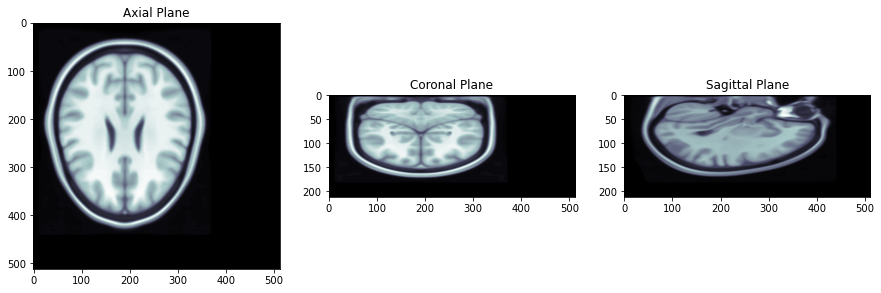

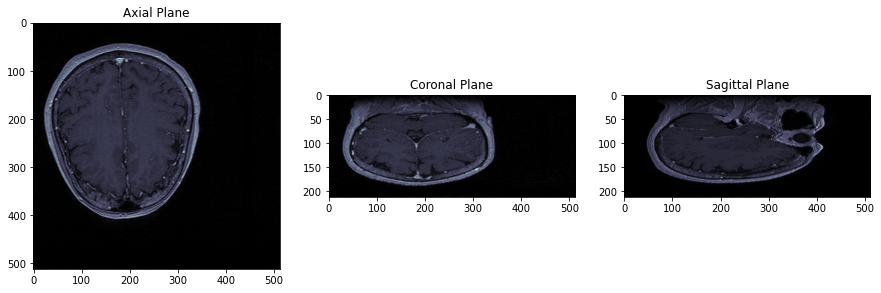

In [337]:
image_to_plot = padded_array

plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(image_to_plot[100, :, :], cmap='bone', aspect = 1)
plt.title("Axial Plane")

plt.subplot(1, 3, 2)
plt.imshow(image_to_plot[:, 150, :], cmap='bone', aspect = 1)
plt.title("Coronal Plane")

plt.subplot(1, 3, 3)
plt.imshow(image_to_plot[:, :, 250], cmap='bone', aspect = 1)
plt.title("Sagittal Plane")

plt.show()

parameters = np.array([14.4573017, 26.26423349, 66.21335805,  3.14159265,  0.        ,0])
transformed_img = translate_img(block_brain, parameters[0:3])
transformed_img = scipy.ndimage.rotate(transformed_img , 180, axes=(1, 2), reshape=False)

result = transformed_img
#transformed_img = rotate_img(transformed_img, [0,  0.        ,0])

image_to_plot = result

plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(image_to_plot[130, :, :], cmap='bone', aspect = 1)
plt.title("Axial Plane")

plt.subplot(1, 3, 2)
plt.imshow(image_to_plot[:, 150, :], cmap='bone', aspect = 1)
plt.title("Coronal Plane")

plt.subplot(1, 3, 3)
plt.imshow(image_to_plot[:, :, 250], cmap='bone', aspect = 1)
plt.title("Sagittal Plane")

plt.show()

## Visualize the Thalamus region

In [197]:
atlas_path = "./brain-data/AAL3_1mm.dcm"
atlas = dicom.dcmread(atlas_path)

C:\Users\minah\AppData\Local\Temp/ipykernel_25364/1045984027.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


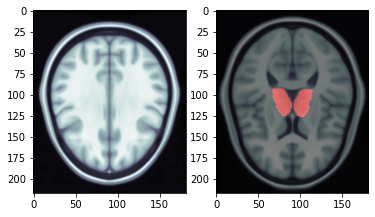

Thalamus volume:
  >> Result: 16699 mm^3
Thalamus surface:
  >> Result: 7106.0 mm^2


In [287]:
import matplotlib.cm
from skimage.morphology import binary_dilation, binary_erosion
def get_thalamus_mask(img_atlas: np.ndarray) -> np.ndarray:
    # get the thalamus region
    mask = np.zeros_like(img_atlas)
    for i in range(121, 151):
        mask[img_atlas == i] = 1
    return mask

def find_centroid(mask: np.ndarray) -> np.ndarray:
    idcs = np.where(mask == 1)
    centroid = np.stack([
        np.mean(idcs[0]),
        np.mean(idcs[1]),
        np.mean(idcs[2]),
    ])
    return centroid

def visualize_axial_slice(
        img: np.ndarray,
        mask: np.ndarray,
        mask_centroid: np.ndarray,
        dim=0
        ):
    """ Visualize the axial slice (firs dim.) of a single region with alpha fusion. """
    img_slice = img[mask_centroid[dim].astype('int'), :, :]
    mask_slice = mask[mask_centroid[dim].astype('int'), :, :]

    cmap = matplotlib.cm.get_cmap('bone')
    norm = matplotlib.colors.Normalize(vmin=np.amin(img_slice), vmax=np.amax(img_slice))
    fused_slice = \
        0.5*cmap(norm(img_slice))[..., :3] + \
        0.5*np.stack([mask_slice, np.zeros_like(mask_slice), np.zeros_like(mask_slice)], axis=-1)
    plt.imshow(fused_slice)
    plt.show()


def find_region_volume(region_mask):
    """ Returns the volume of the region in mm^3. """
    return np.sum(region_mask)


def find_region_surface(mask):
    """ Returns the surface of the region in mm^2. """
    inner_surface = mask - binary_erosion(mask, np.ones((3, 3, 3)))
    outer_surface = binary_dilation(mask, np.ones((3, 3, 3))) - mask
    return (np.sum(inner_surface) + np.sum(outer_surface) ) / 2     # Average of inner and outer surface

# Load data
dcm_phantom = dicom.dcmread("./brain-data/icbm_avg_152_t1_tal_nlin_symmetric_VI.dcm")
img_phantom = dcm_phantom.pixel_array[6:-6, 6:-6, 6:-6]     # Crop phantom to atlas size
dcm_atlas = dicom.dcmread('./brain-data/AAL3_1mm.dcm')
img_atlas = dcm_atlas.pixel_array

fig, axs = plt.subplots(1, 2)
axs[0].imshow(img_phantom[100, :, :], cmap='bone')
axs[1].imshow(img_atlas[100, :, :], cmap='tab20')
fig.show()

mask = get_thalamus_mask(img_atlas)
mask_centroid = find_centroid(mask)
visualize_axial_slice(img_phantom, mask, mask_centroid)

vol = find_region_volume(mask)
surf = find_region_surface(mask)

print('Thalamus volume:')
print(f'  >> Result: {vol} mm^3')

print('Thalamus surface:')
print(f'  >> Result: {surf} mm^2')



In [283]:
# Inverse transform
scaling_factors = (1, 1/patient_pixel_spacing, 1/patient_pixel_spacing)
#mask = scipy.ndimage.zoom(mask, scaling_factors, order=1) 

pad_channels = (block_brain.shape[0] - mask.shape[0])
pad_height = (block_brain.shape[1] - mask.shape[1])
pad_width = (block_brain.shape[2] - mask.shape[2])

# Pad the array with zeros on the sides
padded_mask = np.pad(mask, ((6, pad_channels-6), (6, pad_height-6), (6, pad_width-6)), mode='constant')
parameters = np.array([14.45730176, 26.26423349, 66.21335805,  3.14159265,  0.        ,0] )
padded_mask = rotate_img(padded_mask, parameters[3:])
padded_mask = translate_img(padded_mask, parameters[0:3])

padded_mask.shape


(212, 512, 512)

In [284]:
mask_centroid_transformed = find_centroid(padded_mask)

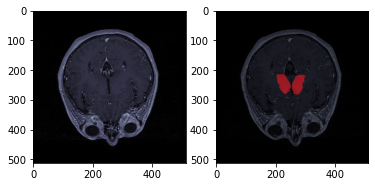

In [286]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(block_brain[100, :, :], cmap='bone')
visualize_axial_slice(block_brain, padded_mask, mask_centroid_transformed)

NameError: name 'cm' is not defined

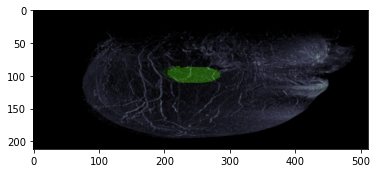

In [291]:
def rotate_on_axial_plane(img_dcm: np.ndarray, angle_in_degrees: float) -> np.ndarray:
    """ Rotate the image on the axial plane. """
    return scipy.ndimage.rotate(img_dcm, angle_in_degrees, axes=(1, 2), reshape=False)
def MIP_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the sagittal orientation. """
    return np.max(img_dcm, axis=2)

def apply_cmap(img, cmap_name, normalize=True) -> np.ndarray:
    """ Apply a colormap to a 2D image. """
    if normalize:
        img = (img - np.min(img))/np.ptp(img)
    cmap_function = matplotlib.cm.get_cmap(cmap_name)
    return cmap_function(img)


def visualize_alpha_fusion(image: np.ndarray, mask: np.ndarray, alpha, visualize = True):
    """ Visualize both image and mask in the same plot. """
    # threshold image
    img = image.copy()
    img[img < 200] = 200
    img[img > 1500] = 1500
    img_cmapped = apply_cmap(img, cmap_name='bone')    # Why 'bone'?
    mask_bone_cmapped = apply_cmap(mask, cmap_name='prism')     # Why 'prism'?
    mask_bone_cmapped = mask_bone_cmapped * mask[..., np.newaxis].astype('bool')
    img_new = img_cmapped * (1-alpha) + mask_bone_cmapped * alpha
    if visualize:
        plt.figure(figsize=(15, 8))
        plt.subplot(1, 3, 1)
        plt.imshow(img_cmapped)
        plt.title('CT Scan')

        # Plot segmentation mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask_bone_cmapped)
        plt.title('Segmentation')

        plt.subplot(1, 3, 3)
        plt.imshow(img_cmapped * (1-alpha) + mask_bone_cmapped * alpha, aspect=1)
        plt.title(f'Segmentation with alpha {alpha}')
        #plt.colorbar()
        plt.show()
    else:
        return img_new

alpha = 0.3
fig, ax = plt.subplots()

#   Create projections
n = 36
projections = []
for idx, rot in enumerate(np.linspace(0, 360*(n-1)/n, num=n)):
    # first, rotate the CT image block
    rotated_img = rotate_on_axial_plane(block_brain, rot)
    # then, rotate the segmentation block
    rotated_seg = rotate_on_axial_plane(padded_mask, rot)
    
    projection_img = MIP_sagittal_plane(rotated_img)
    projection_seg = MIP_sagittal_plane(rotated_seg)
    
    projection = visualize_alpha_fusion(projection_img, projection_seg, alpha, visualize = False)
    plt.imshow(projection) #, cmap=cm, vmin=img_min, vmax=img_max, aspect=pixel_len_mm[0] / pixel_len_mm[1])
    plt.savefig(f'./Projection_{idx}.png')      # Save animation
    projections.append(projection)  # Save for later animation

MovieWriter ffmpeg unavailable; using Pillow instead.


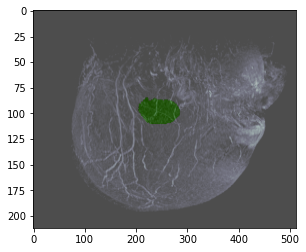

In [295]:
from matplotlib import animation
# Save and visualize animation
cm = matplotlib.cm.get_cmap('bone')
animation_data = [
    [plt.imshow(img, animated=True, cmap=cm, 
             aspect=2)]
    for img in projections
]
anim = animation.ArtistAnimation(fig, animation_data,
                          interval=250, blit=True)
anim.save('./Animation_brain.gif')  # Save animation
plt.show()   # Show animation
